In [18]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns


print("All libraries imported successfully!")

All libraries imported successfully!


In [19]:
# Load data
df = pd.read_csv('../data/marketing_campaign.csv')
print("Original data shape:", df.shape)

# Create a copy for cleaning
df_clean = df.copy()

# 1. Add Campaign column (A/B Test simulation)
np.random.seed(42)  # For reproducible results
df_clean['Campaign'] = np.random.choice(['Campaign_A', 'Campaign_B'], size=len(df_clean))

# 2. Clean Marital Status
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Divorced': 'Single', 
    'Widow': 'Single',
    'Alone': 'Single',
    'YOLO': 'Single',
    'Married': 'Partner',
    'Together': 'Partner'
})

# 3. Calculate Age and Age Group
df_clean['Age'] = 2024 - df_clean['Year_Birth']
df_clean['Age_Group'] = pd.cut(df_clean['Age'], 
                              bins=[0, 35, 55, 100], 
                              labels=['Young', 'Middle-Aged', 'Senior'])

# 4. Handle NULL Income (fill with mean)
income_mean = df_clean['Income'].mean()
df_clean['Income'] = df_clean['Income'].fillna(income_mean)

# 5. Calculate Total Spent
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_clean['Total_Spent'] = df_clean[spending_cols].sum(axis=1)

print("Data cleaning completed!")
print("New columns added:", ['Campaign', 'Age', 'Age_Group', 'Total_Spent'])
print("Cleaned data shape:", df_clean.shape)
display(df_clean[['Campaign', 'Age', 'Age_Group', 'Total_Spent', 'Response']].head())

Original data shape: (2240, 29)
Data cleaning completed!
New columns added: ['Campaign', 'Age', 'Age_Group', 'Total_Spent']
Cleaned data shape: (2240, 33)


,Campaign,Age,Age_Group,Total_Spent,Response
0,Campaign_A,67,Senior,1617,1
1,Campaign_B,70,Senior,27,0
2,Campaign_A,59,Senior,776,0
3,Campaign_A,40,Middle-Aged,53,0
4,Campaign_A,43,Middle-Aged,422,0


In [20]:
# Cohort analysis - Conversion rates by Campaign and Age Group
cohort_results = df_clean.groupby(['Campaign', 'Age_Group']).agg(
    Total_Customers=('Response', 'count'),
    Conversions=('Response', 'sum'),
    Conversion_Rate=('Response', lambda x: (x.sum() / len(x)) * 100)
).round(2).reset_index()

print("Cohort Analysis Results:")
display(cohort_results.sort_values(['Campaign', 'Conversion_Rate'], ascending=[True, False]))

Cohort Analysis Results:


C:\Users\ghola\AppData\Local\Temp\ipykernel_15004\3740381530.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort_results = df_clean.groupby(['Campaign', 'Age_Group']).agg(


,Campaign,Age_Group,Total_Customers,Conversions,Conversion_Rate
0,Campaign_A,Young,45,7,15.56
1,Campaign_A,Middle-Aged,600,88,14.67
2,Campaign_A,Senior,499,57,11.42
3,Campaign_B,Young,46,8,17.39
4,Campaign_B,Middle-Aged,544,93,17.10
5,Campaign_B,Senior,503,81,16.10


In [21]:
print("--- T-Test: Average Spend by Campaign ---")

# Get data for each campaign
campaign_a = df_clean[df_clean['Campaign'] == 'Campaign_A']['Total_Spent']
campaign_b = df_clean[df_clean['Campaign'] == 'Campaign_B']['Total_Spent']

print(f"Campaign A: {len(campaign_a)} samples, Mean: ₹{campaign_a.mean():.2f}")
print(f"Campaign B: {len(campaign_b)} samples, Mean: ₹{campaign_b.mean():.2f}")

# Perform t-test
t_stat, p_value = stats.ttest_ind(campaign_a, campaign_b, equal_var=False)
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("RESULT: Significant difference! Campaigns perform differently.")
else:
    print("RESULT: No significant difference found.")

print("\n" + "="*50)

print("--- Chi-Square Test: Conversion vs Campaign ---")

# Create contingency table
contingency_table = pd.crosstab(df_clean['Campaign'], df_clean['Response'])
print("Contingency Table:")
display(contingency_table)

# Chi-square test
chi2, pval, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-Square: {chi2:.4f}, P-Value: {pval:.4f}")

if pval < alpha:
    print("RESULT: Significant association! Conversion depends on campaign.")
else:
    print("RESULT: No significant association found.")

--- T-Test: Average Spend by Campaign ---
Campaign A: 1145 samples, Mean: ₹599.83
Campaign B: 1095 samples, Mean: ₹612.04
T-Statistic: -0.4792, P-Value: 0.6319
❌ RESULT: No significant difference found.

--- Chi-Square Test: Conversion vs Campaign ---
Contingency Table:


Response,0,1
Campaign,,
Campaign_A,993,152
Campaign_B,913,182


Chi-Square: 4.6786, P-Value: 0.0305
✅ RESULT: Significant association! Conversion depends on campaign.


In [22]:
print("--- Campaign Performance Summary ---")

# Calculate conversion rates
campaign_performance = df_clean.groupby('Campaign').agg(
    Total_Customers=('Response', 'count'),
    Conversions=('Response', 'sum'),
    Conversion_Rate=('Response', lambda x: (x.sum() / len(x)) * 100),
    Avg_Spend=('Total_Spent', 'mean')
).round(2)

display(campaign_performance)

# Calculate lift
rate_a = campaign_performance.loc['Campaign_A', 'Conversion_Rate']
rate_b = campaign_performance.loc['Campaign_B', 'Conversion_Rate']
lift = ((rate_b - rate_a) / rate_a) * 100

print(f"\n📊 Campaign B has a {lift:.1f}% higher conversion rate than Campaign A!")

--- Campaign Performance Summary ---


,Total_Customers,Conversions,Conversion_Rate,Avg_Spend
Campaign,,,,
Campaign_A,1145,152,13.28,599.83
Campaign_B,1095,182,16.62,612.04



📊 Campaign B has a 25.2% higher conversion rate than Campaign A!


In [23]:
# Save the cleaned data for Tableau
df_clean.to_csv('marketing_campaign_cleaned.csv', index=False)
print("Cleaned data saved as 'marketing_campaign_cleaned.csv'")
print("Ready for Tableau dashboard!")

✅ Cleaned data saved as 'marketing_campaign_cleaned.csv'
Ready for Tableau dashboard!


In [10]:
# Export the final cleaned data for Tableau
final_data_query = "SELECT * FROM customers"
final_df = pd.read_sql_query(final_data_query, conn)

# Save to new CSV
final_df.to_csv('marketing_campaign_cleaned.csv', index=False)
print("Cleaned data saved as 'marketing_campaign_cleaned.csv' for Tableau!")

✅ Cleaned data saved as 'marketing_campaign_cleaned.csv' for Tableau!


C:\Users\ghola\AppData\Local\Temp\ipykernel_15004\449195550.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_rates = df_clean.groupby('Age_Group')['Response'].mean() * 100


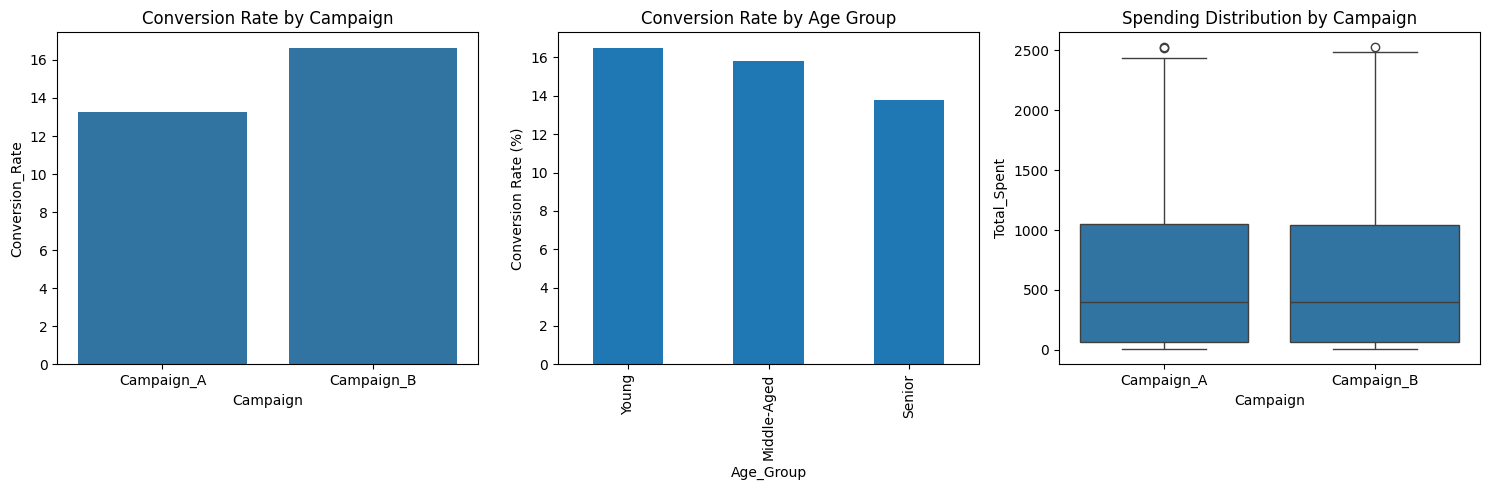

In [26]:
# Quick visual check
plt.figure(figsize=(15, 5))

# Subplot 1: Conversion Rates by Campaign
plt.subplot(1, 3, 1)
sns.barplot(data=campaign_performance.reset_index(), x='Campaign', y='Conversion_Rate')
plt.title('Conversion Rate by Campaign')

# Subplot 2: Conversion Rates by Age Group
plt.subplot(1, 3, 2)
age_group_rates = df_clean.groupby('Age_Group')['Response'].mean() * 100
age_group_rates.plot(kind='bar')
plt.title('Conversion Rate by Age Group')
plt.ylabel('Conversion Rate (%)')

# Subplot 3: Average Spend by Campaign
plt.subplot(1, 3, 3)
sns.boxplot(data=df_clean, x='Campaign', y='Total_Spent')
plt.title('Spending Distribution by Campaign')

plt.tight_layout()
plt.show()

In [27]:
# Set up beautiful styling
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
print("Seaborn styling applied! 🎨")

Seaborn styling applied! 🎨


📊 DEMOGRAPHIC INSIGHTS


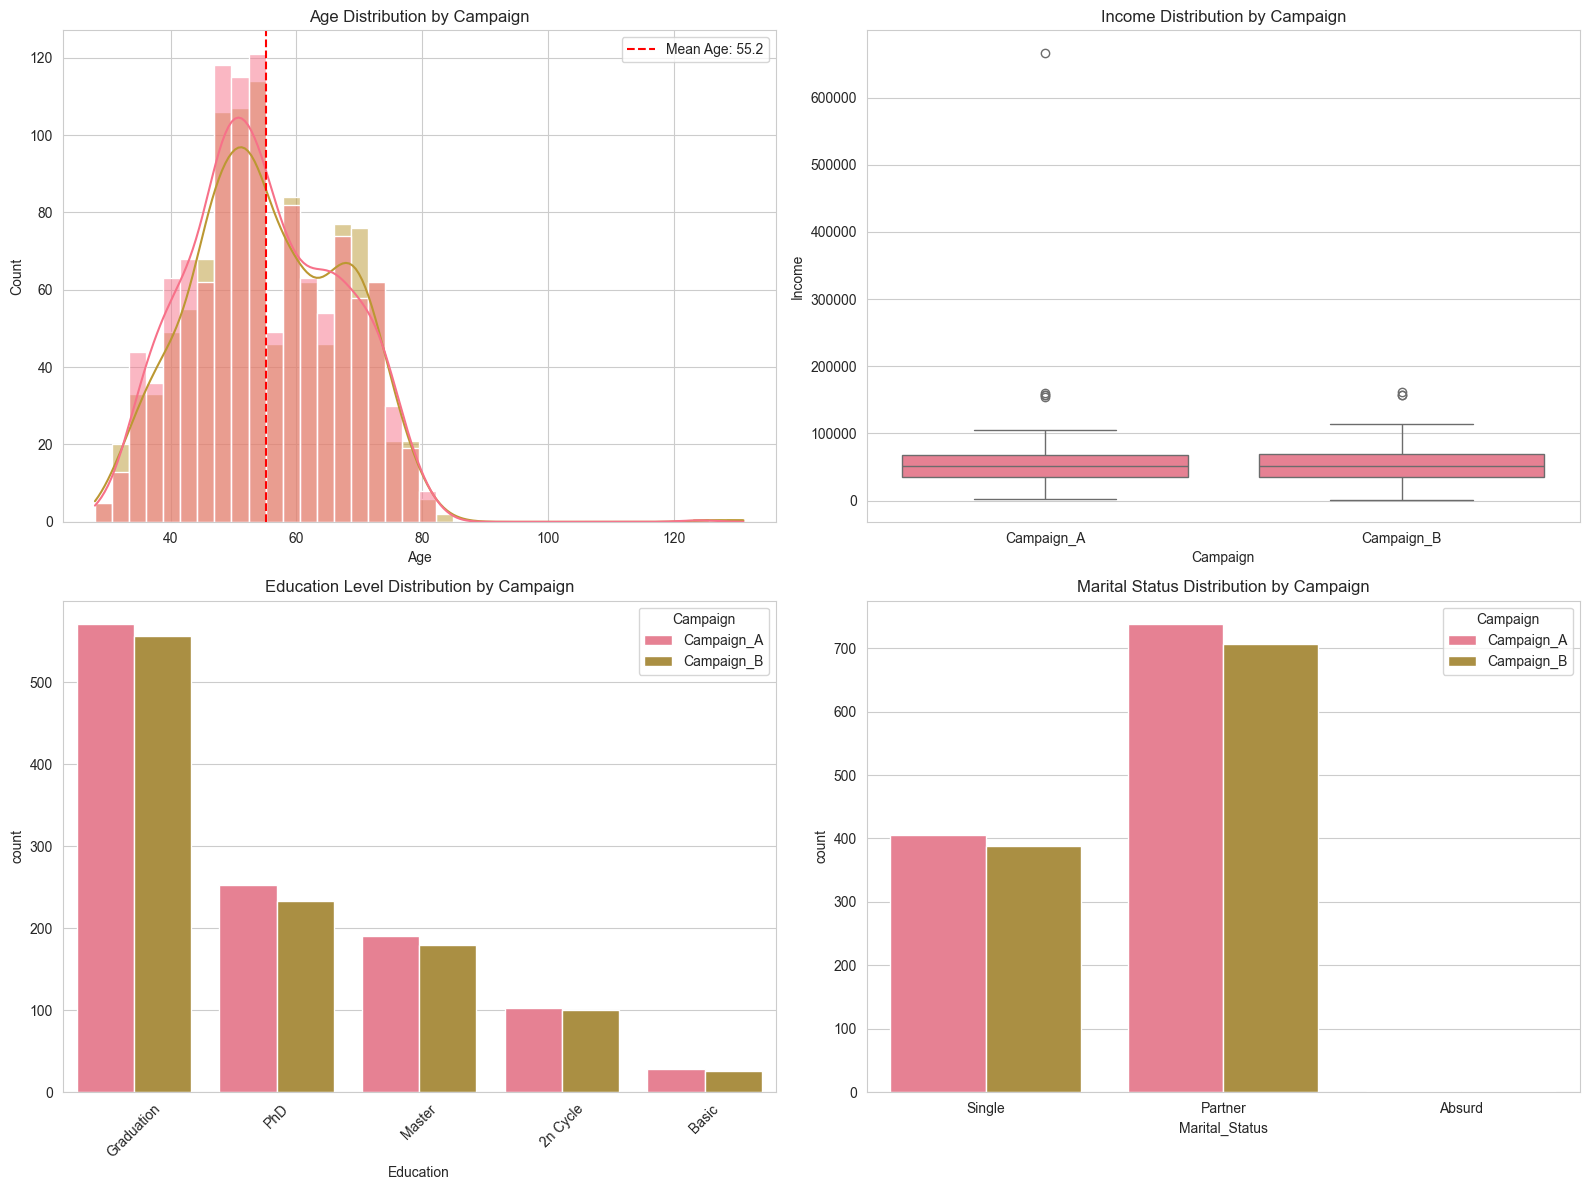

In [28]:
print("DEMOGRAPHIC INSIGHTS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Age Distribution by Campaign
sns.histplot(data=df_clean, x='Age', hue='Campaign', kde=True, ax=axes[0,0])
axes[0,0].set_title('Age Distribution by Campaign')
axes[0,0].axvline(df_clean['Age'].mean(), color='red', linestyle='--', label=f'Mean Age: {df_clean["Age"].mean():.1f}')
axes[0,0].legend()

# 2. Income Distribution
sns.boxplot(data=df_clean, x='Campaign', y='Income', ax=axes[0,1])
axes[0,1].set_title('Income Distribution by Campaign')

# 3. Education Level Analysis
education_order = df_clean['Education'].value_counts().index
sns.countplot(data=df_clean, x='Education', hue='Campaign', ax=axes[1,0], order=education_order)
axes[1,0].set_title('Education Level Distribution by Campaign')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Marital Status Analysis
sns.countplot(data=df_clean, x='Marital_Status', hue='Campaign', ax=axes[1,1])
axes[1,1].set_title('Marital Status Distribution by Campaign')

plt.tight_layout()
plt.show()

🎯 CAMPAIGN PERFORMANCE DEEP DIVE


C:\Users\ghola\AppData\Local\Temp\ipykernel_15004\613819663.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_campaign_conv = df_clean.groupby(['Age_Group', 'Campaign'])['Response'].mean().reset_index()
C:\Users\ghola\AppData\Local\Temp\ipykernel_15004\613819663.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_by_age = df_clean.groupby(['Age_Group', 'Campaign'])['Total_Spent'].mean().reset_index()


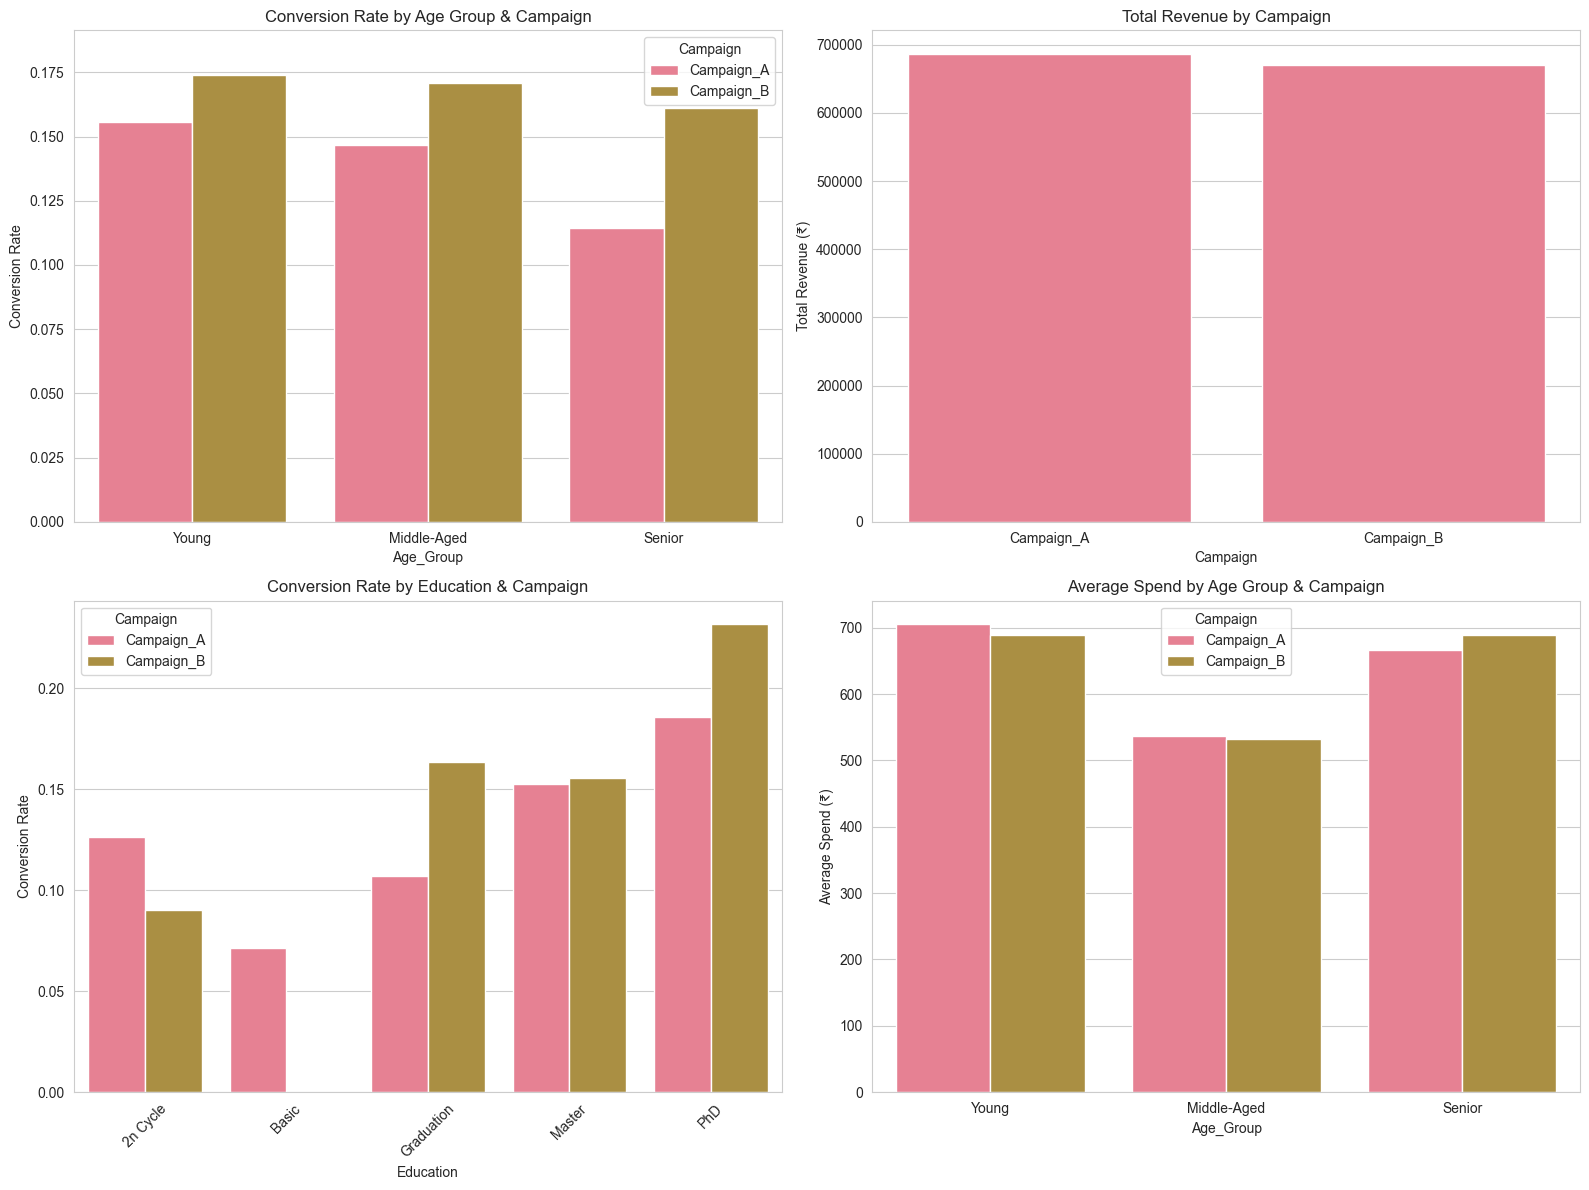

In [29]:
print("CAMPAIGN PERFORMANCE DEEP DIVE")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Conversion Rate by Age Group and Campaign
age_campaign_conv = df_clean.groupby(['Age_Group', 'Campaign'])['Response'].mean().reset_index()
sns.barplot(data=age_campaign_conv, x='Age_Group', y='Response', hue='Campaign', ax=axes[0,0])
axes[0,0].set_title('Conversion Rate by Age Group & Campaign')
axes[0,0].set_ylabel('Conversion Rate')
axes[0,0].set_ylim(0, age_campaign_conv['Response'].max() * 1.1)

# 2. Total Revenue by Campaign
revenue_by_campaign = df_clean.groupby('Campaign')['Total_Spent'].sum().reset_index()
sns.barplot(data=revenue_by_campaign, x='Campaign', y='Total_Spent', ax=axes[0,1])
axes[0,1].set_title('Total Revenue by Campaign')
axes[0,1].set_ylabel('Total Revenue (₹)')

# 3. Conversion Rate by Education
education_conv = df_clean.groupby(['Education', 'Campaign'])['Response'].mean().reset_index()
sns.barplot(data=education_conv, x='Education', y='Response', hue='Campaign', ax=axes[1,0])
axes[1,0].set_title('Conversion Rate by Education & Campaign')
axes[1,0].set_ylabel('Conversion Rate')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Average Spend by Age Group
spend_by_age = df_clean.groupby(['Age_Group', 'Campaign'])['Total_Spent'].mean().reset_index()
sns.barplot(data=spend_by_age, x='Age_Group', y='Total_Spent', hue='Campaign', ax=axes[1,1])
axes[1,1].set_title('Average Spend by Age Group & Campaign')
axes[1,1].set_ylabel('Average Spend (₹)')

plt.tight_layout()
plt.show()

👥 CUSTOMER BEHAVIOR ANALYSIS


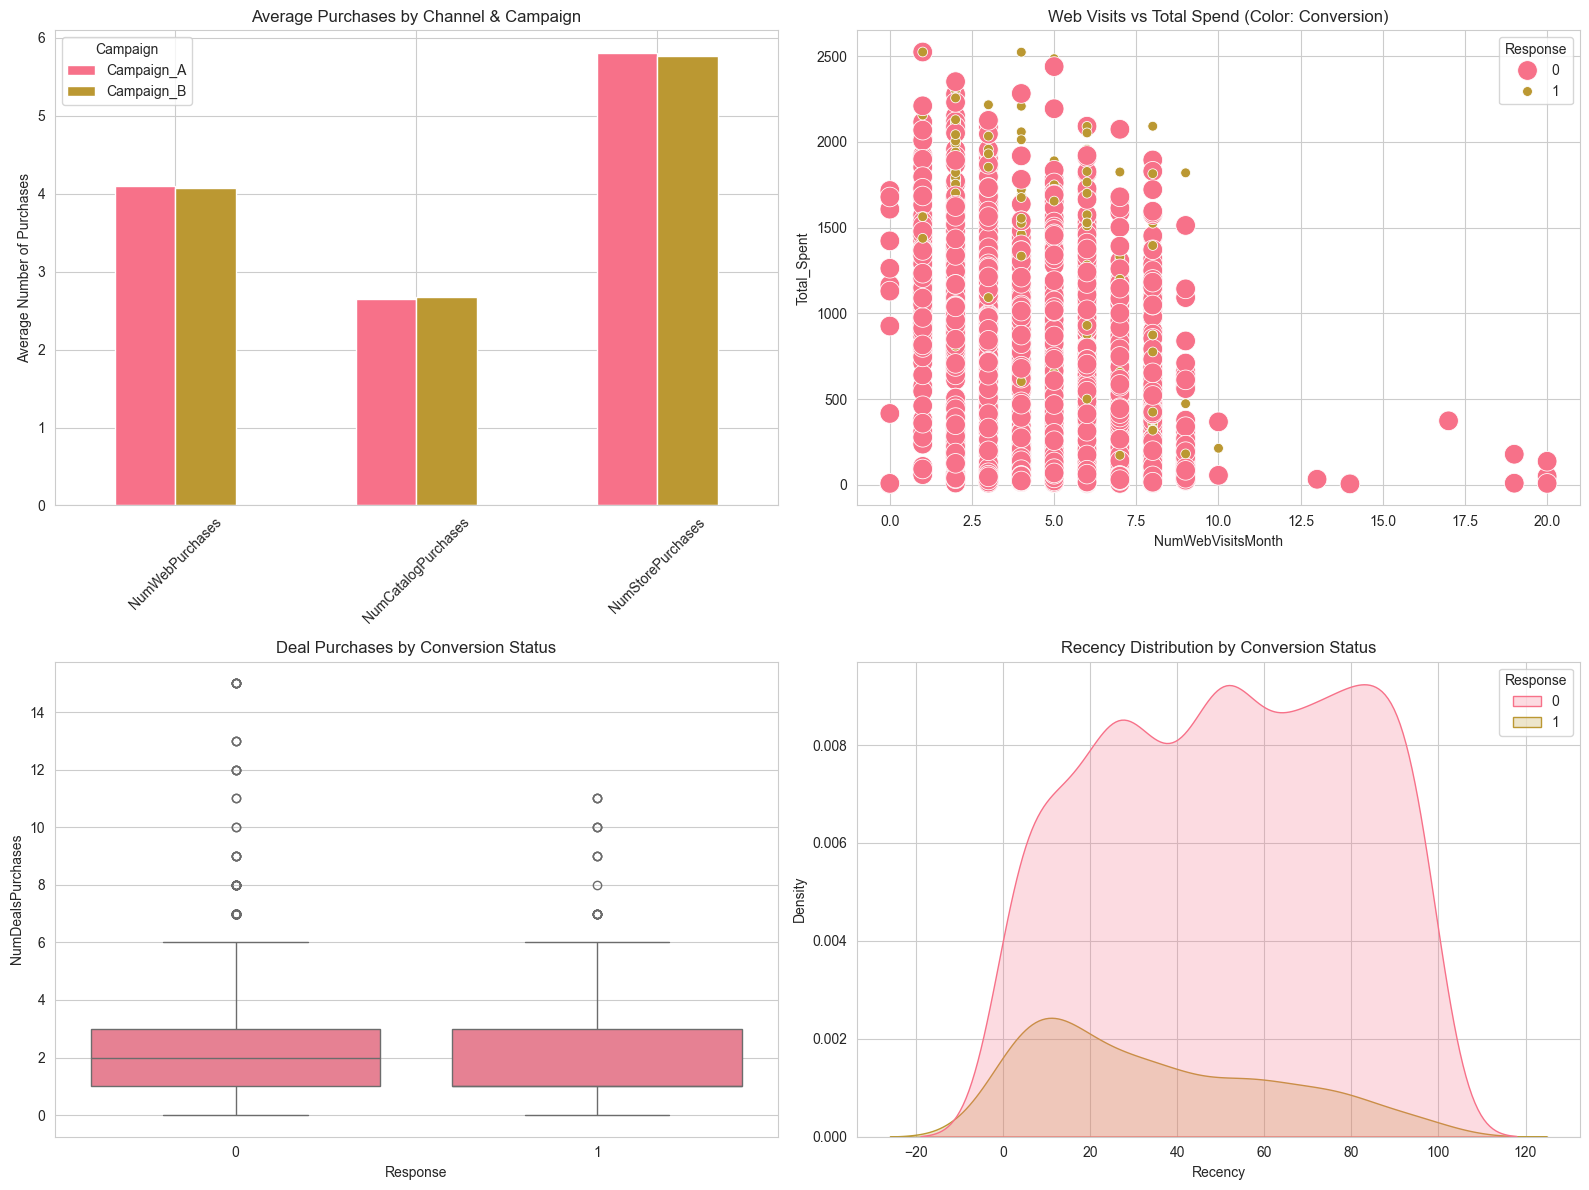

In [30]:
print("CUSTOMER BEHAVIOR ANALYSIS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Purchasing Channels by Campaign
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
purchase_means = df_clean.groupby('Campaign')[purchase_cols].mean().T

purchase_means.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Average Purchases by Channel & Campaign')
axes[0,0].set_ylabel('Average Number of Purchases')
axes[0,0].legend(title='Campaign')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Web Visits vs Conversion
sns.scatterplot(data=df_clean, x='NumWebVisitsMonth', y='Total_Spent', 
                hue='Response', size='Response', sizes=(50, 200), ax=axes[0,1])
axes[0,1].set_title('Web Visits vs Total Spend (Color: Conversion)')

# 3. Deal Purchases Analysis
sns.boxplot(data=df_clean, x='Response', y='NumDealsPurchases', ax=axes[1,0])
axes[1,0].set_title('Deal Purchases by Conversion Status')

# 4. Recency vs Conversion
sns.kdeplot(data=df_clean, x='Recency', hue='Response', fill=True, ax=axes[1,1])
axes[1,1].set_title('Recency Distribution by Conversion Status')

plt.tight_layout()
plt.show()

🔗 CORRELATION ANALYSIS


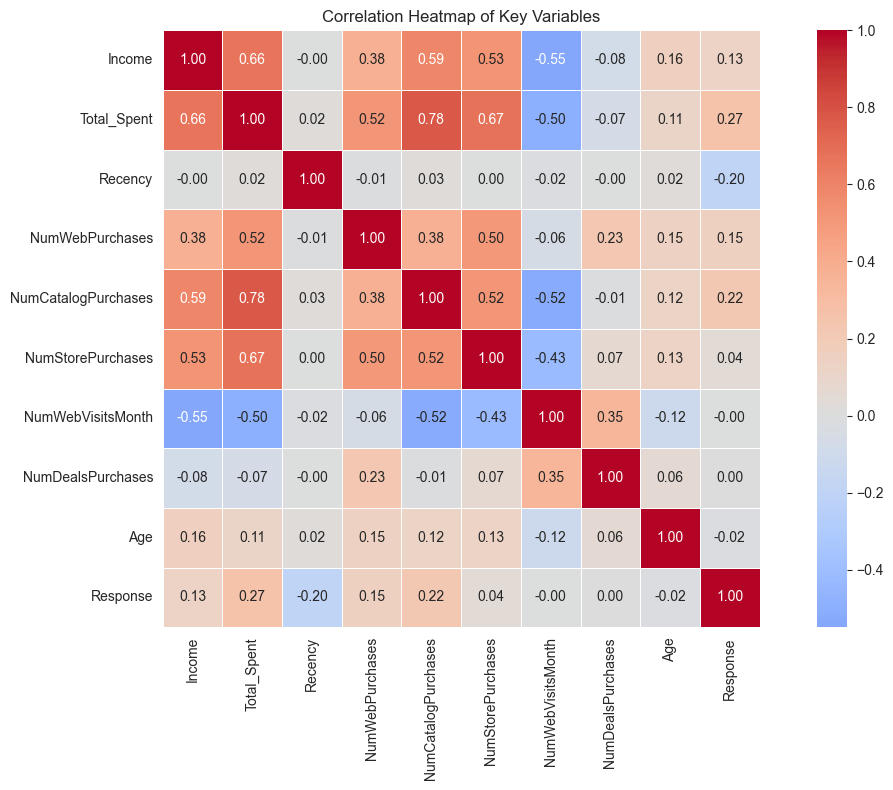


Top correlations with Response (Conversion):
Response               1.000000
Total_Spent            0.265298
NumCatalogPurchases    0.220810
Recency               -0.198437
NumWebPurchases        0.148730
Income                 0.132756
Name: Response, dtype: float64


In [31]:
print("CORRELATION ANALYSIS")
print("="*50)

# Select numeric columns for correlation
numeric_cols = ['Income', 'Total_Spent', 'Recency', 'NumWebPurchases', 
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
                'NumDealsPurchases', 'Age', 'Response']

corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Key Variables')
plt.tight_layout()
plt.show()

# Show top correlations with Response
print("\nTop correlations with Response (Conversion):")
response_corr = corr_matrix['Response'].sort_values(key=abs, ascending=False)
print(response_corr.head(6))

📈 EXECUTIVE SUMMARY DASHBOARD


C:\Users\ghola\AppData\Local\Temp\ipykernel_15004\3620170286.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_performance = df_clean.groupby('Age_Group').agg({


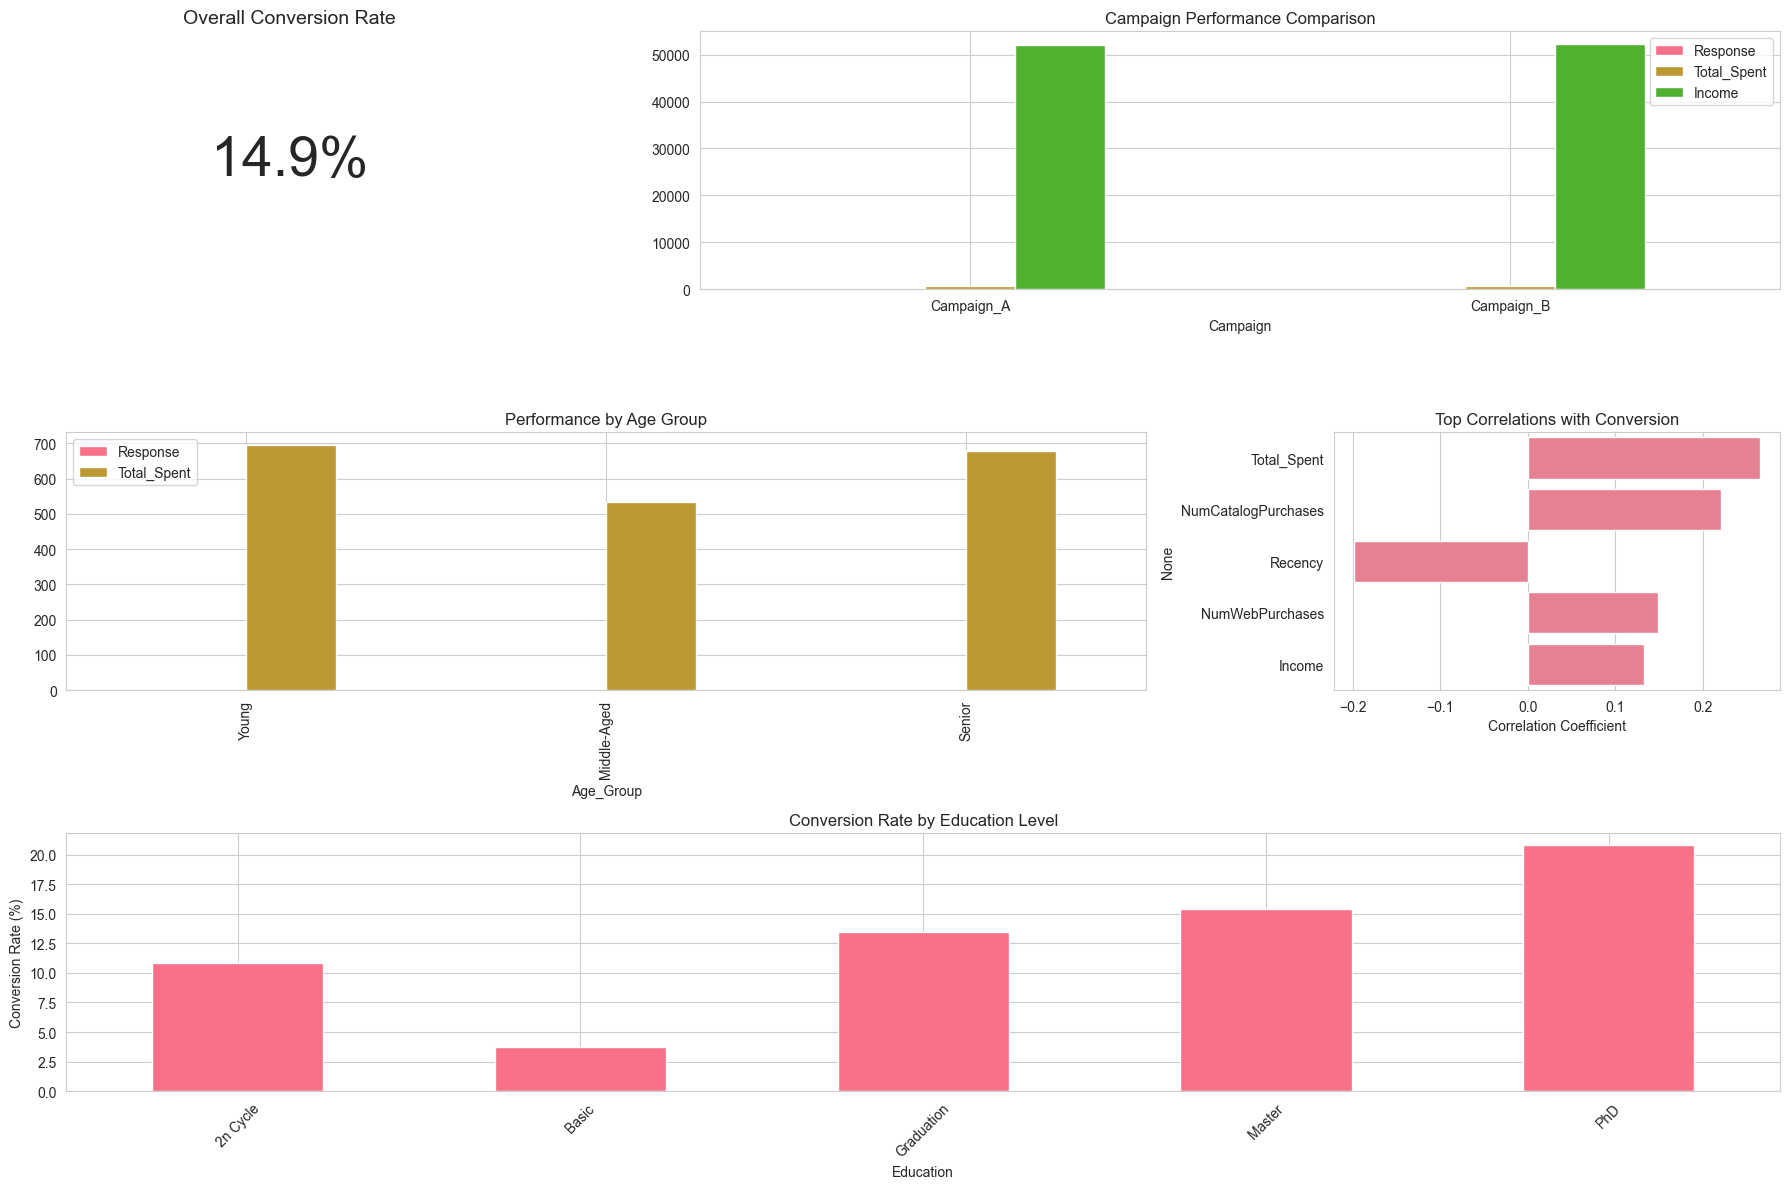

In [32]:
print("EXECUTIVE SUMMARY DASHBOARD")
print("="*50)

# Create a summary figure
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3)

# 1. Overall Conversion Rate (Big number)
ax1 = fig.add_subplot(gs[0, 0])
overall_conv = df_clean['Response'].mean() * 100
ax1.text(0.5, 0.5, f'{overall_conv:.1f}%', fontsize=40, ha='center', va='center')
ax1.set_title('Overall Conversion Rate', fontsize=14)
ax1.axis('off')

# 2. Campaign Comparison
ax2 = fig.add_subplot(gs[0, 1:])
campaign_stats = df_clean.groupby('Campaign').agg({
    'Response': 'mean',
    'Total_Spent': 'mean',
    'Income': 'mean'
}).round(2)
campaign_stats.plot(kind='bar', ax=ax2)
ax2.set_title('Campaign Performance Comparison')
ax2.tick_params(axis='x', rotation=0)

# 3. Age Group Performance
ax3 = fig.add_subplot(gs[1, :2])
age_performance = df_clean.groupby('Age_Group').agg({
    'Response': 'mean',
    'Total_Spent': 'mean'
})
age_performance.plot(kind='bar', ax=ax3)
ax3.set_title('Performance by Age Group')

# 4. Top Correlations
ax4 = fig.add_subplot(gs[1, 2])
top_corrs = response_corr.head(6).drop('Response')
sns.barplot(x=top_corrs.values, y=top_corrs.index, ax=ax4)
ax4.set_title('Top Correlations with Conversion')
ax4.set_xlabel('Correlation Coefficient')

# 5. Conversion Funnel by Education
ax5 = fig.add_subplot(gs[2, :])
education_funnel = df_clean.groupby(['Education', 'Response']).size().unstack()
education_funnel['Conversion_Rate'] = education_funnel[1] / (education_funnel[0] + education_funnel[1]) * 100
education_funnel['Conversion_Rate'].plot(kind='bar', ax=ax5)
ax5.set_title('Conversion Rate by Education Level')
ax5.set_ylabel('Conversion Rate (%)')
ax5.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

✅ Visualizations completed and saved!
🎯 Key insights ready for business decisions!


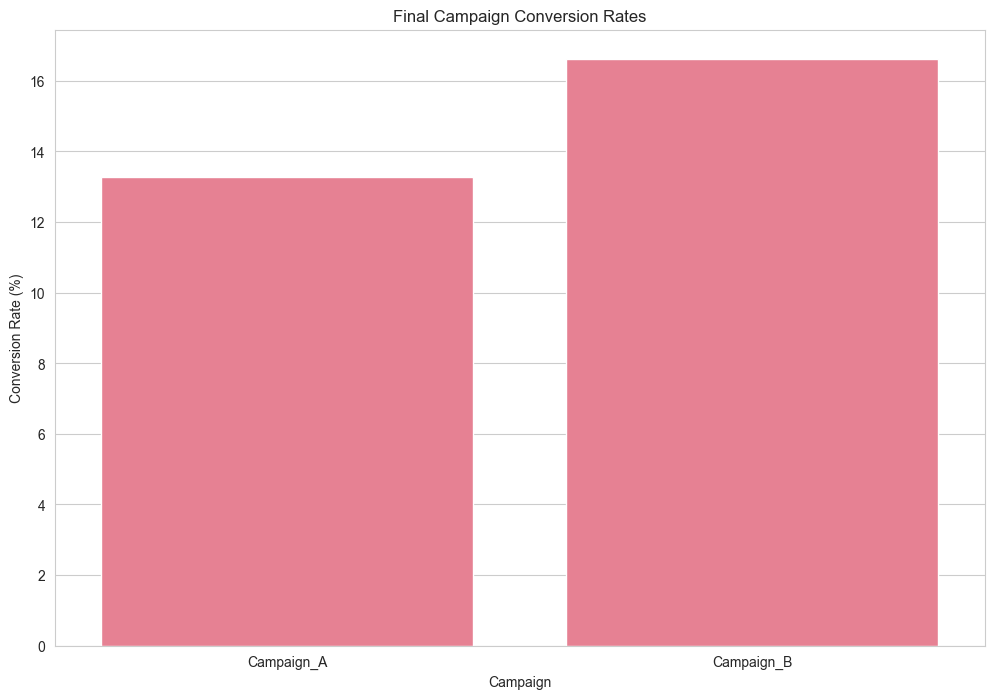

In [33]:
# Save the main visualizations
plt.figure(figsize=(12, 8))
sns.barplot(data=campaign_performance.reset_index(), x='Campaign', y='Conversion_Rate')
plt.title('Final Campaign Conversion Rates')
plt.ylabel('Conversion Rate (%)')
plt.savefig('campaign_performance.png', dpi=300, bbox_inches='tight')

print("Visualizations completed and saved!")
print("Key insights ready for business decisions!")

In [34]:
# Cell 15: Power BI Data Preparation
print("📁 PREPARING DATA FOR POWER BI")
print("="*50)

# Create a final optimized dataset for Power BI
powerbi_data = df_clean[[
    'ID', 'Campaign', 'Age', 'Age_Group', 'Education', 'Marital_Status', 
    'Income', 'Total_Spent', 'Response', 'Recency', 'NumWebPurchases',
    'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
    'NumDealsPurchases', 'Kidhome', 'Teenhome'
]].copy()

# Convert Response to Yes/No for better readability in Power BI
powerbi_data['Conversion_Status'] = powerbi_data['Response'].map({1: 'Converted', 0: 'Not Converted'})

# Create spending categories for better analysis
powerbi_data['Spending_Category'] = pd.cut(powerbi_data['Total_Spent'],
                                          bins=[0, 100, 500, 1000, 5000, 10000],
                                          labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Create income segments
powerbi_data['Income_Segment'] = pd.cut(powerbi_data['Income'],
                                       bins=[0, 30000, 60000, 90000, 120000, 150000],
                                       labels=['Low', 'Medium', 'High', 'Very High', 'Premium'])

# Save the optimized dataset
powerbi_data.to_csv('marketing_campaign_powerbi_ready.csv', index=False)

print("✅ Power BI-ready data saved!")
print(f"📊 Dataset shape: {powerbi_data.shape}")
print("📋 Columns available for Power BI:")
for col in powerbi_data.columns:
    print(f"   • {col}")

display(powerbi_data.head(3))

📁 PREPARING DATA FOR POWER BI
✅ Power BI-ready data saved!
📊 Dataset shape: (2240, 20)
📋 Columns available for Power BI:
   • ID
   • Campaign
   • Age
   • Age_Group
   • Education
   • Marital_Status
   • Income
   • Total_Spent
   • Response
   • Recency
   • NumWebPurchases
   • NumCatalogPurchases
   • NumStorePurchases
   • NumWebVisitsMonth
   • NumDealsPurchases
   • Kidhome
   • Teenhome
   • Conversion_Status
   • Spending_Category
   • Income_Segment


,ID,Campaign,Age,Age_Group,Education,Marital_Status,Income,Total_Spent,Response,Recency,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,NumDealsPurchases,Kidhome,Teenhome,Conversion_Status,Spending_Category,Income_Segment
0,5524,Campaign_A,67,Senior,Graduation,Single,58138.0,1617,1,58,8,10,4,7,3,0,0,Converted,High,Medium
1,2174,Campaign_B,70,Senior,Graduation,Single,46344.0,27,0,38,1,1,2,5,2,1,1,Not Converted,Very Low,Medium
2,4141,Campaign_A,59,Senior,Graduation,Partner,71613.0,776,0,26,8,2,10,4,1,0,0,Not Converted,Medium,High
